<a href="https://colab.research.google.com/github/Sruthi1106/INFOSYS-_INTERNSHIP-OIL_SPILL_DETECTION-/blob/sruthi_project/Oil_Spill_Detection_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Import Libraries**

We start by importing the required libraries for handling datasets, images, and augmentations.

os, shutil → file handling

cv2 → image loading & resizing

numpy → numerical arrays

matplotlib → visualization

sklearn → train/validation/test split

albumentations → augmentation

In [2]:
!pip install opencv-python matplotlib albumentations
import os, random, cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Download & Extract Dataset

We download the oil spill dataset from Zenodo and unzip it into the working directory.

In [3]:
!wget -O dataset.zip "https://zenodo.org/record/10555314/files/dataset.zip?download=1"
!unzip -o dataset.zip -d /content/oilspill_dataset


--2025-10-02 09:19:37--  https://zenodo.org/record/10555314/files/dataset.zip?download=1
Resolving zenodo.org (zenodo.org)... 188.185.43.25, 188.185.48.194, 188.185.45.92, ...
Connecting to zenodo.org (zenodo.org)|188.185.43.25|:443... connected.
HTTP request sent, awaiting response... 301 MOVED PERMANENTLY
Location: /records/10555314/files/dataset.zip [following]
--2025-10-02 09:19:37--  https://zenodo.org/records/10555314/files/dataset.zip
Reusing existing connection to zenodo.org:443.
HTTP request sent, awaiting response... 200 OK
Length: 1137552692 (1.1G) [application/octet-stream]
Saving to: ‘dataset.zip’

dataset.zip         100%[===================>]   1.06G  24.5MB/s    in 50s     

2025-10-02 09:20:28 (21.8 MB/s) - ‘dataset.zip’ saved [1137552692/1137552692]

Archive:  dataset.zip
  inflating: /content/oilspill_dataset/label_colors.txt  
  inflating: /content/oilspill_dataset/test/images/Oil (1007).jpg  
  inflating: /content/oilspill_dataset/test/images/Oil (1019).jpg  
  inf

# **Define base directories**

Here we set up the base directory for our dataset and confirm paths for images and masks.

We prepare a structured dataset by creating separate subfolders for training, validation, and testing images and masks. This makes the dataset well-organized for deep learning workflows.

In [4]:
base_dir = "/content/oilspill_dataset"

train_img_dir = os.path.join(base_dir, "train/images")
train_mask_dir = os.path.join(base_dir, "train/masks")
val_img_dir   = os.path.join(base_dir, "val/images")
val_mask_dir  = os.path.join(base_dir, "val/masks")
test_img_dir  = os.path.join(base_dir, "test/images")
test_mask_dir = os.path.join(base_dir, "test/masks")

print("✅ Paths set")


✅ Paths set


# Visualize Samples

We visualize a few image–mask pairs to confirm dataset correctness.
This ensures images and masks are aligned.

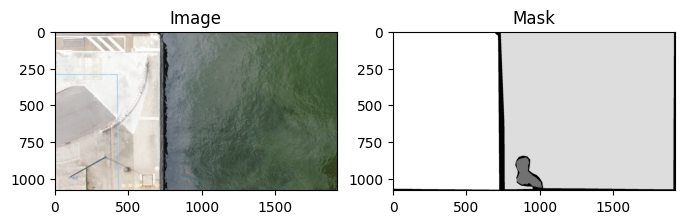

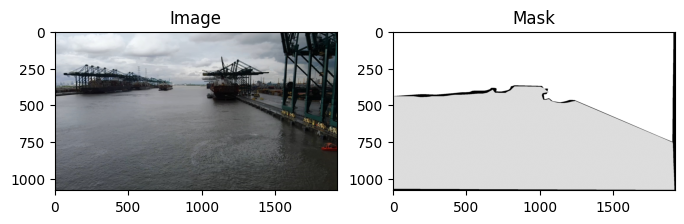

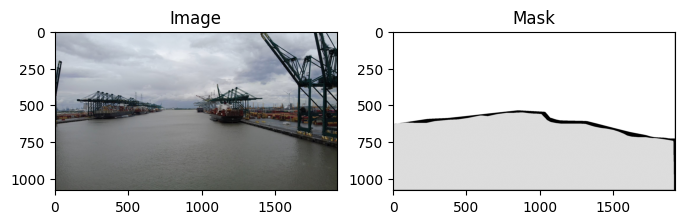

In [5]:
def show_samples(img_dir, mask_dir, n=3):
    files = sorted(os.listdir(img_dir))[:n]
    for f in files:
        img = cv2.imread(os.path.join(img_dir, f))
        mask = cv2.imread(os.path.join(mask_dir, os.path.splitext(f)[0]+".png"), cv2.IMREAD_GRAYSCALE)
        plt.figure(figsize=(8,4))
        plt.subplot(1,2,1); plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)); plt.title("Image")
        plt.subplot(1,2,2); plt.imshow(mask, cmap="gray"); plt.title("Mask")
        plt.show()

show_samples(train_img_dir, train_mask_dir)


# Resize & Normalize a Sample

We load one image–mask pair, resize them to 256×256, and normalize the image pixels to [0,1].

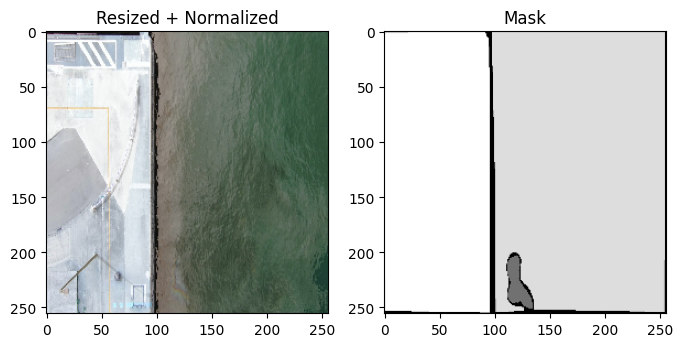

In [6]:
img_path = os.path.join(train_img_dir, sorted(os.listdir(train_img_dir))[0])
mask_path = os.path.join(train_mask_dir, sorted(os.listdir(train_mask_dir))[0])

img = cv2.imread(img_path)
mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

resized_img = cv2.resize(img, (256, 256)) / 255.0
resized_mask = cv2.resize(mask, (256, 256))

plt.figure(figsize=(8,4))
plt.subplot(1,2,1); plt.imshow(resized_img); plt.title("Resized + Normalized")
plt.subplot(1,2,2); plt.imshow(resized_mask, cmap="gray"); plt.title("Mask")
plt.show()


# Define Preprocessing & Augmentation Pipeline

We build a preprocessing pipeline with:

* Resize (256×256) → fixed input size for the model

* Normalization → scale pixels to [-1,1]

* Augmentations → flips, rotations, brightness, Gaussian blur (to mimic SAR noise reduction)

In [7]:
import albumentations as A
train_transform = A.Compose([
    A.Resize(256, 256),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Rotate(limit=30, p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    A.GaussianBlur(blur_limit=3, p=0.3)
])

val_transform = A.Compose([
    A.Resize(256, 256)
])


In [8]:
import albumentations as A

# Training augmentations
train_transform = A.Compose([
    A.Resize(256, 256),                  # resize to 256x256
    A.HorizontalFlip(p=0.5),             # flip horizontally
    A.VerticalFlip(p=0.5),               # flip vertically
    A.Rotate(limit=30, p=0.5),           # random rotation
    A.RandomBrightnessContrast(p=0.5),   # brightness/contrast change
    A.GaussianBlur(blur_limit=3, p=0.3)  # blur to mimic SAR noise reduction
])

# Validation/Test only resized (no heavy augmentations)
val_transform = A.Compose([
    A.Resize(256, 256)
])


# Test Augmentation on One Sample

We apply the training augmentations to one image–mask pair and visualize the result.

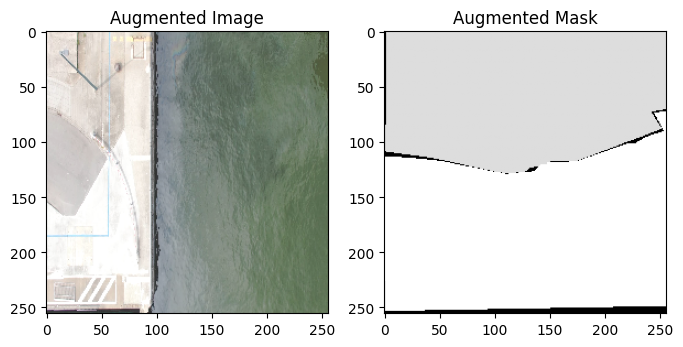

In [9]:
img_path = os.path.join(train_img_dir, sorted(os.listdir(train_img_dir))[0])
mask_path = os.path.join(train_mask_dir, os.path.splitext(os.listdir(train_img_dir)[0])[0] + ".png")

img = cv2.imread(img_path)
mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

# Ensure both are the same size before augmentation
mask = cv2.resize(mask, (img.shape[1], img.shape[0]), interpolation=cv2.INTER_NEAREST)

augmented = train_transform(image=img, mask=mask)
aug_img, aug_mask = augmented["image"], augmented["mask"]

plt.figure(figsize=(8,4))
plt.subplot(1,2,1); plt.imshow(cv2.cvtColor(aug_img, cv2.COLOR_BGR2RGB)); plt.title("Augmented Image")
plt.subplot(1,2,2); plt.imshow(aug_mask, cmap="gray"); plt.title("Augmented Mask")
plt.show()


# Custom Data Generator (Keras Sequence)

We create a custom generator to:

* Load images & masks in batches

* Apply augmentations automatically

* Normalize images to [0,1]

* Convert masks to binary format (0/1)

In [10]:
from tensorflow.keras.utils import Sequence

class OilSpillDataset(Sequence):
    def __init__(self, img_dir, mask_dir, batch_size=4, img_size=256, channels=3, augment=None, shuffle=True):
        self.img_files = sorted(os.listdir(img_dir))
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.batch_size = batch_size
        self.img_size = img_size
        self.channels = channels
        self.augment = augment
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.img_files) / self.batch_size))

    def __getitem__(self, idx):
        batch_files = self.img_files[idx*self.batch_size:(idx+1)*self.batch_size]
        images, masks = [], []
        for f in batch_files:
            # Load image
            img = cv2.imread(os.path.join(self.img_dir, f))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            # Load mask (same name, but PNG)
            mask_name = os.path.splitext(f)[0] + ".png"
            mask = cv2.imread(os.path.join(self.mask_dir, mask_name), cv2.IMREAD_GRAYSCALE)

            # Ensure mask matches image size
            mask = cv2.resize(mask, (img.shape[1], img.shape[0]), interpolation=cv2.INTER_NEAREST)

            # Apply augmentation if given
            if self.augment:
                augmented = self.augment(image=img, mask=mask)
                img, mask = augmented["image"], augmented["mask"]

            # Resize again to model input size
            img = cv2.resize(img, (self.img_size, self.img_size))
            mask = cv2.resize(mask, (self.img_size, self.img_size), interpolation=cv2.INTER_NEAREST)

            # Normalize
            img = img.astype("float32") / 255.0
            mask = (mask > 127).astype("float32")[..., np.newaxis]

            if self.channels == 1:
                img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)[..., np.newaxis]

            images.append(img)
            masks.append(mask)

        return np.array(images), np.array(masks)

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.img_files)


# Create Training & Validation Generators

We now create train_gen and val_gen using the custom class.
This ensures data is loaded in batches during model training.

Batch images shape: (4, 256, 256, 3)
Batch masks shape: (4, 256, 256, 1)


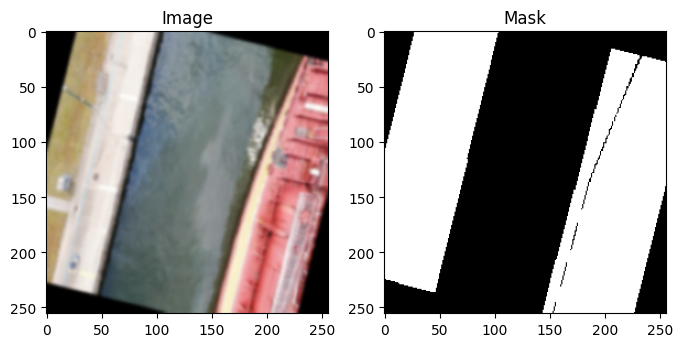

In [11]:
train_gen = OilSpillDataset(
    train_img_dir, train_mask_dir,
    batch_size=4, img_size=256, channels=3,
    augment=train_transform, shuffle=True
)

val_gen = OilSpillDataset(
    val_img_dir, val_mask_dir,
    batch_size=4, img_size=256, channels=3,
    augment=val_transform, shuffle=False
)

# Test one batch
x, y = train_gen[0]
print("Batch images shape:", x.shape)
print("Batch masks shape:", y.shape)

# Visualize first sample
plt.figure(figsize=(8,4))
plt.subplot(1,2,1); plt.imshow(x[0]); plt.title("Image")
plt.subplot(1,2,2); plt.imshow(y[0].squeeze(), cmap="gray"); plt.title("Mask")
plt.show()



# Milestone 2 Model Development + Training & Evaluation


# Import Libraries

We import all required libraries:

OpenCV & Albumentations → image preprocessing & augmentation

TensorFlow/Keras → deep learning framework for U-Net

scikit-learn metrics → extra evaluation metrics (precision, recall, IoU)

In [12]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import albumentations as A
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.utils import Sequence
from sklearn.metrics import precision_score, recall_score, accuracy_score


# Parameters

We define hyperparameters and dataset paths:

* IMG_SIZE → image resolution

* CHANNELS → 3 for RGB, 1 for grayscale SAR

* BATCH_SIZE → number of images per training batch

* EPOCHS → maximum number of training epochs (stopped early with callbacks)

In [13]:
IMG_SIZE = 256       # image resolution
CHANNELS = 3         # 3 for RGB, 1 for SAR grayscale
BATCH_SIZE = 8       # safe and fast for Colab GPU
EPOCHS = 50          # with early stopping ~25-30 epochs

BASE_DIR = "/content/oilspill_dataset"
TRAIN_IMG_DIR = os.path.join(BASE_DIR, "train/images")
TRAIN_MASK_DIR = os.path.join(BASE_DIR, "train/masks")
VAL_IMG_DIR   = os.path.join(BASE_DIR, "val/images")
VAL_MASK_DIR  = os.path.join(BASE_DIR, "val/masks")
TEST_IMG_DIR  = os.path.join(BASE_DIR, "test/images")
TEST_MASK_DIR = os.path.join(BASE_DIR, "test/masks")

print(f"IMG_SIZE={IMG_SIZE}, CHANNELS={CHANNELS}, BATCH_SIZE={BATCH_SIZE}, EPOCHS={EPOCHS}")


IMG_SIZE=256, CHANNELS=3, BATCH_SIZE=8, EPOCHS=50


# U-Net Building Blocks

Defines helper functions to build encoder, bottleneck, and decoder parts of U-Net.
Each block uses Conv2D → BatchNorm → ReLU layers to learn spatial features.

In [14]:
def conv_block(x, filters):
    x = layers.Conv2D(filters, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.Conv2D(filters, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    return x

def encoder_block(x, filters):
    c = conv_block(x, filters)
    p = layers.MaxPooling2D((2,2))(c)
    return c, p

def decoder_block(x, skip, filters):
    x = layers.UpSampling2D((2,2))(x)
    x = layers.Concatenate()([x, skip])
    x = conv_block(x, filters)
    return x


# Build U-Net Model

Assembles the complete U-Net architecture with:

* Encoder (downsampling with pooling)

* Bottleneck (deep feature extraction)

* Decoder (upsampling with skip connections)

* Sigmoid output for binary segmentation

In [15]:
def build_unet(input_shape=(IMG_SIZE, IMG_SIZE, CHANNELS)):
    inputs = layers.Input(shape=input_shape)

    c1, p1 = encoder_block(inputs, 64)
    c2, p2 = encoder_block(p1, 128)
    c3, p3 = encoder_block(p2, 256)
    c4, p4 = encoder_block(p3, 512)

    bn = conv_block(p4, 1024)

    d4 = decoder_block(bn, c4, 512)
    d3 = decoder_block(d4, c3, 256)
    d2 = decoder_block(d3, c2, 128)
    d1 = decoder_block(d2, c1, 64)

    outputs = layers.Conv2D(1, 1, activation="sigmoid")(d1)
    return Model(inputs, outputs)

model = build_unet()
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │      1,792 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 256, 256,  │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │     36,928 │ activation[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ activation_1[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        512 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │    147,584 │ activation_2[0][… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        512 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ activation_3[0][… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │      1,024 │ conv2d_4[0][0]  

 Total params: 31,402,497 (119.79 MB)

 Trainable params: 31,390,721 (119.75 MB)

 Non-trainable params: 11,776 (46.00 KB)

# Loss Functions & Metrics
We define segmentation-specific functions:

* Dice Coefficient → overlap between prediction & ground truth

* IoU (Intersection over Union) → quality of segmentation regions

* BCE + Dice Loss → balances pixel-level accuracy with region overlap

In [16]:
def dice_coef(y_true, y_pred, smooth=1e-6):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    inter = K.sum(y_true_f * y_pred_f)
    return (2.*inter + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def iou_score(y_true, y_pred, smooth=1e-6):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    inter = K.sum(y_true_f * y_pred_f)
    union = K.sum(y_true_f) + K.sum(y_pred_f) - inter
    return (inter+smooth)/(union+smooth)

def bce_dice_loss(y_true, y_pred):
    bce = tf.keras.losses.BinaryCrossentropy()(y_true, y_pred)
    return bce + (1 - dice_coef(y_true, y_pred))


# Compile Model

We configure training:
*   Optimizer → Adam (learning rate = 1e-4)
* Loss → BCE + Dice Loss
* Metrics → Accuracy, Dice, IoU




In [17]:
model.compile(
    optimizer=Adam(1e-4),
    loss=bce_dice_loss,
    metrics=["accuracy", dice_coef, iou_score]
)


# Augmentation Pipelines

Defines image augmentation strategies:

* Training → flips, rotation, brightness, Gaussian blur

* Validation → only resize (no random changes)

In [18]:
train_transform = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Rotate(limit=30, p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    A.GaussianBlur(blur_limit=3, p=0.3)
])

val_transform = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE)
])


# Mask Loader

Loads binary segmentation masks and resizes them while preserving class labels.

In [19]:
def load_and_binarize_mask(path, size=(IMG_SIZE, IMG_SIZE)):
    mask = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    mask = cv2.resize(mask, size, interpolation=cv2.INTER_NEAREST)
    return (mask > 127).astype("float32")


# Data Generator

A custom generator (based on Keras Sequence) to:

* Load images + masks in batches

* Apply augmentations

* Normalize inputs to [0,1]

* Ensure compatibility with training loop

In [20]:
class OilSpillDataset(Sequence):
    def __init__(self, img_dir, mask_dir, batch_size=BATCH_SIZE, img_size=IMG_SIZE, channels=CHANNELS, augment=None, shuffle=True):
        self.img_files = sorted(os.listdir(img_dir))
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.batch_size = batch_size
        self.img_size = img_size
        self.channels = channels
        self.augment = augment
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.img_files) / self.batch_size))

    def __getitem__(self, idx):
        batch_files = self.img_files[idx*self.batch_size:(idx+1)*self.batch_size]
        images, masks = [], []
        for f in batch_files:
            img = cv2.imread(os.path.join(self.img_dir, f))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            mask = cv2.imread(os.path.join(self.mask_dir, os.path.splitext(f)[0]+".png"), cv2.IMREAD_GRAYSCALE)

            if mask.shape[:2] != img.shape[:2]:
                mask = cv2.resize(mask, (img.shape[1], img.shape[0]), interpolation=cv2.INTER_NEAREST)

            if self.augment:
                augmented = self.augment(image=img, mask=mask)
                img, mask = augmented["image"], augmented["mask"]

            img = cv2.resize(img, (self.img_size, self.img_size)).astype("float32")/255.0
            mask = cv2.resize(mask, (self.img_size, self.img_size), interpolation=cv2.INTER_NEAREST)
            mask = (mask>127).astype("float32")[..., np.newaxis]

            if self.channels == 1:
                img = cv2.cvtColor((img*255).astype("uint8"), cv2.COLOR_RGB2GRAY).astype("float32")/255.0
                img = img[..., np.newaxis]

            images.append(img)
            masks.append(mask)

        return np.array(images), np.array(masks)

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.img_files)


# Create Generators

We instantiate generators for training, validation, and testing.
This organizes data flow into the model.

In [21]:
train_gen = OilSpillDataset(TRAIN_IMG_DIR, TRAIN_MASK_DIR, augment=train_transform, shuffle=True)
val_gen   = OilSpillDataset(VAL_IMG_DIR, VAL_MASK_DIR, augment=val_transform, shuffle=False)
test_gen  = OilSpillDataset(TEST_IMG_DIR, TEST_MASK_DIR, batch_size=1, augment=val_transform, shuffle=False)

print(f"Train batches: {len(train_gen)}, Val batches: {len(val_gen)}, Test batches: {len(test_gen)}")


Train batches: 102, Val batches: 26, Test batches: 254


# Callbacks

We add automation during training:

* ModelCheckpoint → saves best model (lowest val_loss)

* ReduceLROnPlateau → decreases LR if validation stalls

* EarlyStopping → stops training if no improvement

In [22]:
ckpt_path = "/content/unet_oilspill_best.h5"
checkpoint = ModelCheckpoint(ckpt_path, monitor="val_loss", save_best_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=4, verbose=1)
earlystop = EarlyStopping(monitor="val_loss", patience=8, restore_best_weights=True, verbose=1)
callbacks = [checkpoint, reduce_lr, earlystop]


In [23]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

ckpt_path = "/content/unet_oilspill_best.h5"

checkpoint = ModelCheckpoint(
    ckpt_path, monitor="val_loss", save_best_only=True, verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor="val_loss", factor=0.5, patience=3, verbose=1
)

earlystop = EarlyStopping(
    monitor="val_loss", patience=5, restore_best_weights=True, verbose=1
)

callbacks = [checkpoint, reduce_lr, earlystop]


# Train Model

We train the U-Net with our generators, augmentations, and callbacks.
Training usually runs ~25-30 epochs before early stopping.

In [40]:
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=30,            # still keep 50 (it will stop early)
    callbacks=callbacks
)

Epoch 1/30
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 528ms/step - accuracy: 0.9261 - dice_coef: 0.9086 - iou_score: 0.8337 - loss: 0.2859
Epoch 1: val_loss improved from 0.31485 to 0.29690, saving model to /content/unet_oilspill_best.h5


102/102 ━━━━━━━━━━━━━━━━━━━━ 76s 743ms/step - accuracy: 0.9260 - dice_coef: 0.9086 - iou_score: 0.8336 - loss: 0.2862 - val_accuracy: 0.9444 - val_dice_coef: 0.8772 - val_iou_score: 0.7975 - val_loss: 0.2969 - learning_rate: 1.0000e-04
Epoch 2/30
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 526ms/step - accuracy: 0.9120 - dice_coef: 0.8984 - iou_score: 0.8175 - loss: 0.3221
Epoch 2: val_loss did not improve from 0.29690
102/102 ━━━━━━━━━━━━━━━━━━━━ 64s 624ms/step - accuracy: 0.9120 - dice_coef: 0.8984 - iou_score: 0.8175 - loss: 0.3221 - val_accuracy: 0.9218 - val_dice_coef: 0.8895 - val_iou_score: 0.8142 - val_loss: 0.3234 - learning_rate: 1.0000e-04
Epoch 3/30
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 534ms/step - accuracy: 0.9136 - dice_coef: 0.8972 - iou_score: 0.8154 - loss: 0.3266
Epoch 3: val_loss improved from 0.29690 to 0.21984, saving model to /content/unet_oilspill_best.h5


102/102 ━━━━━━━━━━━━━━━━━━━━ 71s 698ms/step - accuracy: 0.9136 - dice_coef: 0.8972 - iou_score: 0.8154 - loss: 0.3265 - val_accuracy: 0.9494 - val_dice_coef: 0.9190 - val_iou_score: 0.8574 - val_loss: 0.2198 - learning_rate: 1.0000e-04
Epoch 4/30
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 529ms/step - accuracy: 0.9061 - dice_coef: 0.8906 - iou_score: 0.8051 - loss: 0.3525
Epoch 4: val_loss did not improve from 0.21984
102/102 ━━━━━━━━━━━━━━━━━━━━ 64s 624ms/step - accuracy: 0.9062 - dice_coef: 0.8908 - iou_score: 0.8053 - loss: 0.3521 - val_accuracy: 0.9411 - val_dice_coef: 0.9053 - val_iou_score: 0.8368 - val_loss: 0.2587 - learning_rate: 1.0000e-04
Epoch 5/30
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 534ms/step - accuracy: 0.9277 - dice_coef: 0.9113 - iou_score: 0.8381 - loss: 0.2765
Epoch 5: val_loss did not improve from 0.21984
102/102 ━━━━━━━━━━━━━━━━━━━━ 65s 632ms/step - accuracy: 0.9276 - dice_coef: 0.9113 - iou_score: 0.8380 - loss: 0.2767 - val_accuracy: 0.9453 - val_dice_coef: 0.9058 - val_iou_sco

102/102 ━━━━━━━━━━━━━━━━━━━━ 78s 764ms/step - accuracy: 0.9385 - dice_coef: 0.9265 - iou_score: 0.8639 - loss: 0.2381 - val_accuracy: 0.9543 - val_dice_coef: 0.9219 - val_iou_score: 0.8613 - val_loss: 0.2117 - learning_rate: 5.0000e-05
Epoch 8/30
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 537ms/step - accuracy: 0.9410 - dice_coef: 0.9248 - iou_score: 0.8611 - loss: 0.2386
Epoch 8: val_loss improved from 0.21174 to 0.19613, saving model to /content/unet_oilspill_best.h5


102/102 ━━━━━━━━━━━━━━━━━━━━ 78s 762ms/step - accuracy: 0.9409 - dice_coef: 0.9247 - iou_score: 0.8610 - loss: 0.2388 - val_accuracy: 0.9581 - val_dice_coef: 0.9243 - val_iou_score: 0.8647 - val_loss: 0.1961 - learning_rate: 5.0000e-05
Epoch 9/30
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 522ms/step - accuracy: 0.9448 - dice_coef: 0.9277 - iou_score: 0.8661 - loss: 0.2276
Epoch 9: val_loss did not improve from 0.19613
102/102 ━━━━━━━━━━━━━━━━━━━━ 64s 618ms/step - accuracy: 0.9448 - dice_coef: 0.9277 - iou_score: 0.8661 - loss: 0.2276 - val_accuracy: 0.9450 - val_dice_coef: 0.9004 - val_iou_score: 0.8335 - val_loss: 0.2500 - learning_rate: 5.0000e-05
Epoch 10/30
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 529ms/step - accuracy: 0.9384 - dice_coef: 0.9229 - iou_score: 0.8580 - loss: 0.2394
Epoch 10: val_loss improved from 0.19613 to 0.19567, saving model to /content/unet_oilspill_best.h5


102/102 ━━━━━━━━━━━━━━━━━━━━ 72s 703ms/step - accuracy: 0.9384 - dice_coef: 0.9229 - iou_score: 0.8580 - loss: 0.2395 - val_accuracy: 0.9566 - val_dice_coef: 0.9276 - val_iou_score: 0.8704 - val_loss: 0.1957 - learning_rate: 5.0000e-05
Epoch 11/30
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 530ms/step - accuracy: 0.9402 - dice_coef: 0.9285 - iou_score: 0.8679 - loss: 0.2392
Epoch 11: val_loss improved from 0.19567 to 0.17719, saving model to /content/unet_oilspill_best.h5


102/102 ━━━━━━━━━━━━━━━━━━━━ 75s 735ms/step - accuracy: 0.9402 - dice_coef: 0.9284 - iou_score: 0.8678 - loss: 0.2393 - val_accuracy: 0.9598 - val_dice_coef: 0.9394 - val_iou_score: 0.8897 - val_loss: 0.1772 - learning_rate: 5.0000e-05
Epoch 12/30
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 522ms/step - accuracy: 0.9401 - dice_coef: 0.9308 - iou_score: 0.8715 - loss: 0.2414
Epoch 12: val_loss did not improve from 0.17719
102/102 ━━━━━━━━━━━━━━━━━━━━ 64s 620ms/step - accuracy: 0.9401 - dice_coef: 0.9308 - iou_score: 0.8715 - loss: 0.2414 - val_accuracy: 0.9348 - val_dice_coef: 0.9097 - val_iou_score: 0.8453 - val_loss: 0.2655 - learning_rate: 5.0000e-05
Epoch 13/30
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 529ms/step - accuracy: 0.9393 - dice_coef: 0.9265 - iou_score: 0.8641 - loss: 0.2365
Epoch 13: val_loss did not improve from 0.17719
102/102 ━━━━━━━━━━━━━━━━━━━━ 64s 625ms/step - accuracy: 0.9393 - dice_coef: 0.9265 - iou_score: 0.8642 - loss: 0.2364 - val_accuracy: 0.9610 - val_dice_coef: 0.9296 - val_iou

102/102 ━━━━━━━━━━━━━━━━━━━━ 71s 692ms/step - accuracy: 0.9460 - dice_coef: 0.9344 - iou_score: 0.8787 - loss: 0.2111 - val_accuracy: 0.9653 - val_dice_coef: 0.9397 - val_iou_score: 0.8904 - val_loss: 0.1651 - learning_rate: 2.5000e-05
Epoch 16/30
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 534ms/step - accuracy: 0.9458 - dice_coef: 0.9340 - iou_score: 0.8770 - loss: 0.2189
Epoch 16: val_loss improved from 0.16515 to 0.16330, saving model to /content/unet_oilspill_best.h5


102/102 ━━━━━━━━━━━━━━━━━━━━ 93s 911ms/step - accuracy: 0.9458 - dice_coef: 0.9340 - iou_score: 0.8770 - loss: 0.2188 - val_accuracy: 0.9640 - val_dice_coef: 0.9399 - val_iou_score: 0.8906 - val_loss: 0.1633 - learning_rate: 2.5000e-05
Epoch 17/30
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 514ms/step - accuracy: 0.9494 - dice_coef: 0.9373 - iou_score: 0.8830 - loss: 0.2045
Epoch 17: val_loss improved from 0.16330 to 0.15236, saving model to /content/unet_oilspill_best.h5


102/102 ━━━━━━━━━━━━━━━━━━━━ 69s 676ms/step - accuracy: 0.9495 - dice_coef: 0.9373 - iou_score: 0.8830 - loss: 0.2043 - val_accuracy: 0.9657 - val_dice_coef: 0.9466 - val_iou_score: 0.9013 - val_loss: 0.1524 - learning_rate: 2.5000e-05
Epoch 18/30
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 521ms/step - accuracy: 0.9520 - dice_coef: 0.9424 - iou_score: 0.8919 - loss: 0.1915
Epoch 18: val_loss did not improve from 0.15236
102/102 ━━━━━━━━━━━━━━━━━━━━ 63s 615ms/step - accuracy: 0.9520 - dice_coef: 0.9424 - iou_score: 0.8918 - loss: 0.1916 - val_accuracy: 0.9633 - val_dice_coef: 0.9432 - val_iou_score: 0.8962 - val_loss: 0.1612 - learning_rate: 2.5000e-05
Epoch 19/30
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 524ms/step - accuracy: 0.9507 - dice_coef: 0.9390 - iou_score: 0.8858 - loss: 0.2008
Epoch 19: val_loss did not improve from 0.15236
102/102 ━━━━━━━━━━━━━━━━━━━━ 64s 624ms/step - accuracy: 0.9507 - dice_coef: 0.9390 - iou_score: 0.8858 - loss: 0.2008 - val_accuracy: 0.9649 - val_dice_coef: 0.9447 - val_iou

102/102 ━━━━━━━━━━━━━━━━━━━━ 93s 913ms/step - accuracy: 0.9537 - dice_coef: 0.9383 - iou_score: 0.8851 - loss: 0.1873 - val_accuracy: 0.9677 - val_dice_coef: 0.9487 - val_iou_score: 0.9052 - val_loss: 0.1444 - learning_rate: 1.2500e-05
Epoch 22/30
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 524ms/step - accuracy: 0.9496 - dice_coef: 0.9397 - iou_score: 0.8875 - loss: 0.2013
Epoch 22: val_loss did not improve from 0.14440
102/102 ━━━━━━━━━━━━━━━━━━━━ 64s 623ms/step - accuracy: 0.9497 - dice_coef: 0.9397 - iou_score: 0.8875 - loss: 0.2013 - val_accuracy: 0.9675 - val_dice_coef: 0.9493 - val_iou_score: 0.9063 - val_loss: 0.1448 - learning_rate: 1.2500e-05
Epoch 23/30
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 521ms/step - accuracy: 0.9499 - dice_coef: 0.9401 - iou_score: 0.8879 - loss: 0.1987
Epoch 23: val_loss did not improve from 0.14440
102/102 ━━━━━━━━━━━━━━━━━━━━ 64s 622ms/step - accuracy: 0.9499 - dice_coef: 0.9402 - iou_score: 0.8880 - loss: 0.1986 - val_accuracy: 0.9668 - val_dice_coef: 0.9474 - val_iou

102/102 ━━━━━━━━━━━━━━━━━━━━ 78s 761ms/step - accuracy: 0.9578 - dice_coef: 0.9472 - iou_score: 0.9002 - loss: 0.1719 - val_accuracy: 0.9685 - val_dice_coef: 0.9507 - val_iou_score: 0.9085 - val_loss: 0.1392 - learning_rate: 6.2500e-06
Epoch 26/30
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 533ms/step - accuracy: 0.9548 - dice_coef: 0.9463 - iou_score: 0.8988 - loss: 0.1811
Epoch 26: val_loss improved from 0.13924 to 0.13877, saving model to /content/unet_oilspill_best.h5


102/102 ━━━━━━━━━━━━━━━━━━━━ 71s 690ms/step - accuracy: 0.9548 - dice_coef: 0.9463 - iou_score: 0.8988 - loss: 0.1810 - val_accuracy: 0.9685 - val_dice_coef: 0.9522 - val_iou_score: 0.9110 - val_loss: 0.1388 - learning_rate: 6.2500e-06
Epoch 27/30
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 532ms/step - accuracy: 0.9612 - dice_coef: 0.9514 - iou_score: 0.9076 - loss: 0.1594
Epoch 27: val_loss did not improve from 0.13877
102/102 ━━━━━━━━━━━━━━━━━━━━ 65s 631ms/step - accuracy: 0.9612 - dice_coef: 0.9513 - iou_score: 0.9076 - loss: 0.1595 - val_accuracy: 0.9679 - val_dice_coef: 0.9500 - val_iou_score: 0.9075 - val_loss: 0.1430 - learning_rate: 6.2500e-06
Epoch 28/30
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 529ms/step - accuracy: 0.9557 - dice_coef: 0.9434 - iou_score: 0.8943 - loss: 0.1817
Epoch 28: val_loss improved from 0.13877 to 0.13860, saving model to /content/unet_oilspill_best.h5


102/102 ━━━━━━━━━━━━━━━━━━━━ 73s 710ms/step - accuracy: 0.9557 - dice_coef: 0.9434 - iou_score: 0.8943 - loss: 0.1816 - val_accuracy: 0.9682 - val_dice_coef: 0.9531 - val_iou_score: 0.9127 - val_loss: 0.1386 - learning_rate: 6.2500e-06
Epoch 29/30
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 534ms/step - accuracy: 0.9583 - dice_coef: 0.9469 - iou_score: 0.8998 - loss: 0.1689
Epoch 29: val_loss did not improve from 0.13860
102/102 ━━━━━━━━━━━━━━━━━━━━ 65s 633ms/step - accuracy: 0.9583 - dice_coef: 0.9469 - iou_score: 0.8998 - loss: 0.1690 - val_accuracy: 0.9677 - val_dice_coef: 0.9492 - val_iou_score: 0.9064 - val_loss: 0.1444 - learning_rate: 6.2500e-06
Epoch 30/30
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 531ms/step - accuracy: 0.9599 - dice_coef: 0.9473 - iou_score: 0.9008 - loss: 0.1658
Epoch 30: val_loss improved from 0.13860 to 0.13778, saving model to /content/unet_oilspill_best.h5


102/102 ━━━━━━━━━━━━━━━━━━━━ 77s 755ms/step - accuracy: 0.9599 - dice_coef: 0.9473 - iou_score: 0.9008 - loss: 0.1659 - val_accuracy: 0.9689 - val_dice_coef: 0.9523 - val_iou_score: 0.9115 - val_loss: 0.1378 - learning_rate: 6.2500e-06
Restoring model weights from the end of the best epoch: 30.


# Plot Training Curves

We visualize:

* Training vs Validation Accuracy

* Training vs Validation Loss

to check if the model is overfitting or improving.

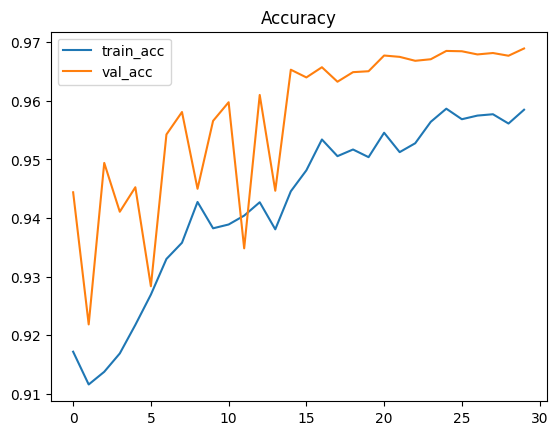

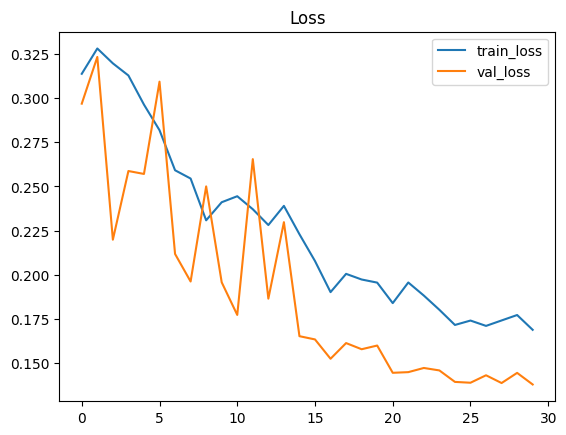

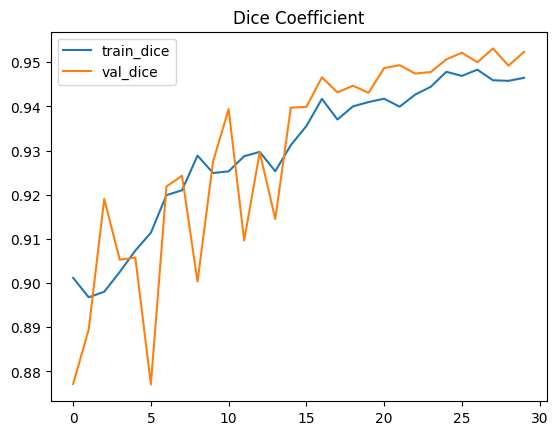

In [41]:
import matplotlib.pyplot as plt

# Accuracy
plt.plot(history.history["accuracy"], label="train_acc")
plt.plot(history.history["val_accuracy"], label="val_acc")
plt.legend(); plt.title("Accuracy"); plt.show()

# Loss
plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.legend(); plt.title("Loss"); plt.show()

# Dice coefficient
if "dice_coef" in history.history:
    plt.plot(history.history["dice_coef"], label="train_dice")
    plt.plot(history.history["val_dice_coef"], label="val_dice")
    plt.legend(); plt.title("Dice Coefficient"); plt.show()

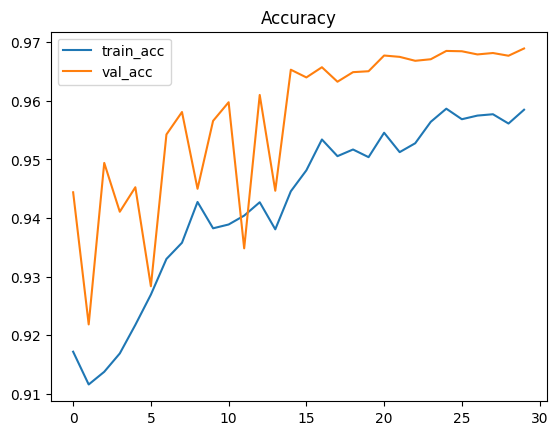

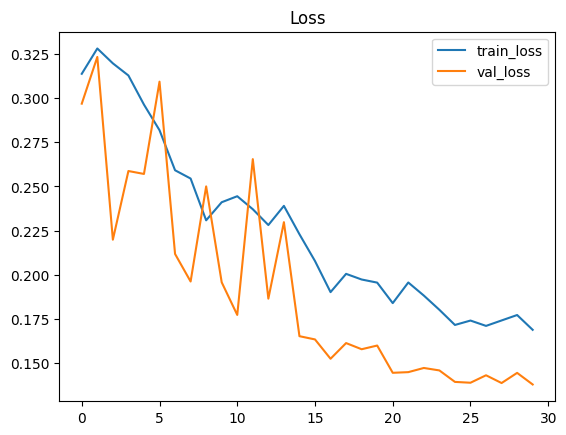

In [42]:
plt.plot(history.history["accuracy"], label="train_acc")
plt.plot(history.history["val_accuracy"], label="val_acc")
plt.legend(); plt.title("Accuracy"); plt.show()

plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.legend(); plt.title("Loss"); plt.show()


# Evaluate on Test Set

We evaluate the saved best model on the test set and print results for:

* Accuracy

* Dice Coefficient

* IoU

In [43]:
model.load_weights(ckpt_path)
results = model.evaluate(test_gen)
print("\nTest Results:")
for n,v in zip(model.metrics_names, results):
    print(f"{n}: {v:.4f}")


254/254 ━━━━━━━━━━━━━━━━━━━━ 20s 55ms/step - accuracy: 0.9637 - dice_coef: 0.9093 - iou_score: 0.8730 - loss: 0.1868

Test Results:
loss: 0.2475
compile_metrics: 0.9557


# Extra Metrics

Computes additional evaluation metrics manually:

Precision → proportion of predicted oil spill pixels that are correct

Recall → proportion of actual oil spill pixels detected

IoU & Dice → region overlap quality

Accuracy → overall correctness

In [44]:
precisions, recalls, accuracies, ious, dices = [], [], [], [], []

for i in range(len(test_gen)):
    x, y_true = test_gen[i]
    y_pred = model.predict(x, verbose=0)
    y_pred_bin = (y_pred[0,...,0]>0.5).astype("uint8")
    y_true_bin = (y_true[0,...,0]>0.5).astype("uint8")

    yp, yt = y_pred_bin.flatten(), y_true_bin.flatten()
    prec = precision_score(yt, yp, zero_division=0)
    rec = recall_score(yt, yp, zero_division=0)
    acc = accuracy_score(yt, yp)
    inter = np.sum(yp*yt)
    union = np.sum(yp)+np.sum(yt)-inter
    iou = (inter+1e-6)/(union+1e-6)
    dice = (2*inter+1e-6)/(np.sum(yp)+np.sum(yt)+1e-6)

    precisions.append(prec); recalls.append(rec); accuracies.append(acc); ious.append(iou); dices.append(dice)

print(f"Precision: {np.mean(precisions):.4f}")
print(f"Recall:    {np.mean(recalls):.4f}")
print(f"Accuracy:  {np.mean(accuracies):.4f}")
print(f"IoU:       {np.mean(ious):.4f}")
print(f"Dice:      {np.mean(dices):.4f}")


Precision: 0.8861
Recall:    0.8912
Accuracy:  0.9557
IoU:       0.8991
Dice:      0.9299


# Visualize Predictions

We show side-by-side:

* Input Satellite Image

* Ground Truth Mask

* Predicted Mask

to visually confirm segmentation quality.

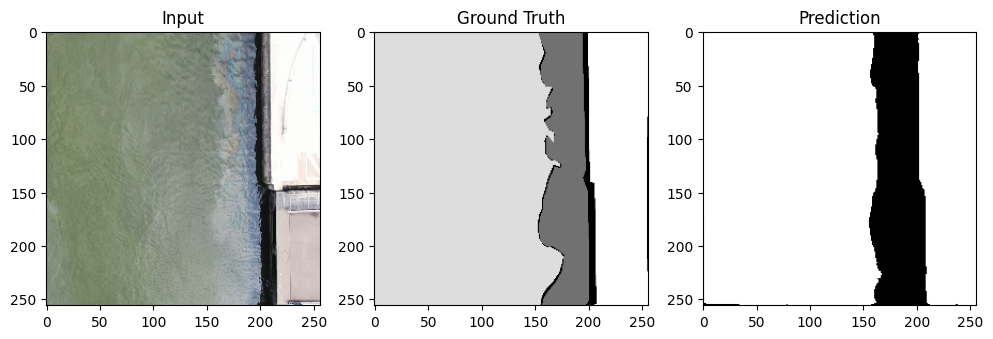

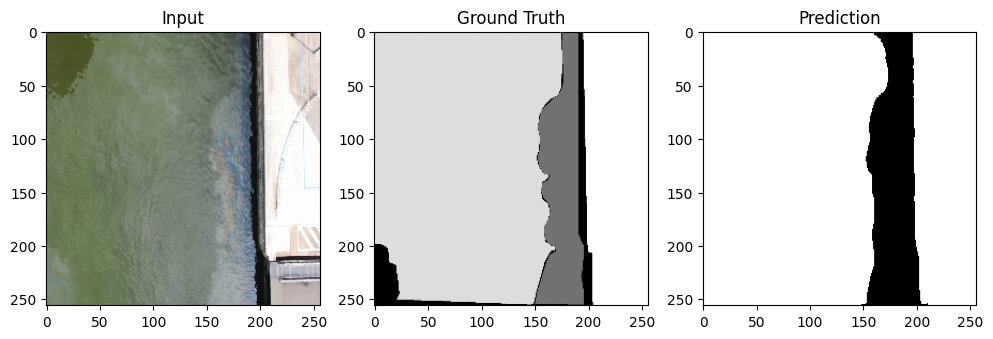

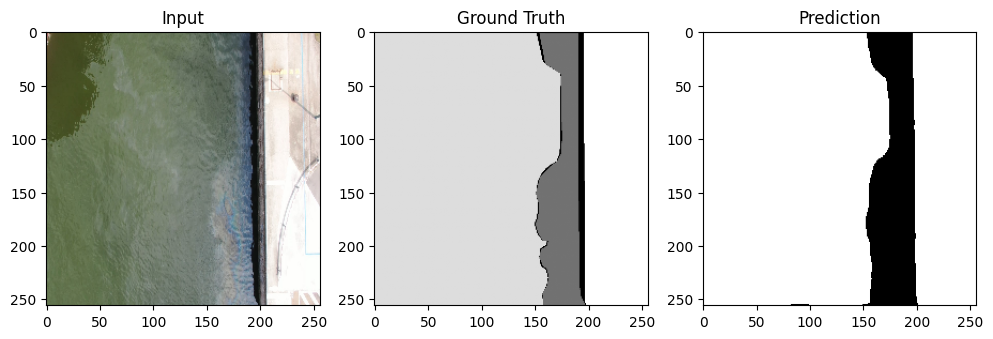

In [45]:
def visualize_prediction(img_path, mask_path, model):
    img = cv2.imread(img_path); img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_resized = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    inp = img_resized.astype("float32")/255.0
    if CHANNELS==1:
        inp = cv2.cvtColor((inp*255).astype("uint8"), cv2.COLOR_RGB2GRAY).astype("float32")/255.0
        inp = inp[..., np.newaxis]
    inp = np.expand_dims(inp, 0)

    pred = model.predict(inp, verbose=0)[0,...,0]
    pred_bin = (pred>0.5).astype("uint8")*255
    gt = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    gt_resized = cv2.resize(gt, (IMG_SIZE, IMG_SIZE))

    plt.figure(figsize=(12,4))
    plt.subplot(1,3,1); plt.imshow(img_resized); plt.title("Input")
    plt.subplot(1,3,2); plt.imshow(gt_resized, cmap="gray"); plt.title("Ground Truth")
    plt.subplot(1,3,3); plt.imshow(pred_bin, cmap="gray"); plt.title("Prediction")
    plt.show()

for f in sorted(os.listdir(TEST_IMG_DIR))[:3]:
    visualize_prediction(os.path.join(TEST_IMG_DIR,f),
                         os.path.join(TEST_MASK_DIR, os.path.splitext(f)[0]+".png"),
                         model)



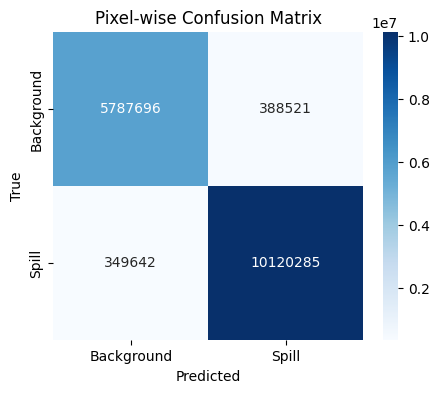

In [49]:
# Collect all predictions + ground truths (flattened)
all_preds, all_trues = [], []

from sklearn.metrics import confusion_matrix # Import confusion_matrix
import seaborn as sns # Import seaborn for heatmap

for i in range(len(test_gen)):
    x, y_true = test_gen[i]
    y_pred = model.predict(x, verbose=0)
    y_pred_bin = (y_pred[0,...,0]>0.5).astype("uint8")
    y_true_bin = (y_true[0,...,0]>0.5).astype("uint8")

    all_preds.extend(y_pred_bin.flatten())
    all_trues.extend(y_true_bin.flatten())

# Confusion matrix
cm = confusion_matrix(all_trues, all_preds)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Background","Spill"], yticklabels=["Background","Spill"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Pixel-wise Confusion Matrix")
plt.show()

In [50]:
# Save the trained model in the new Keras format
save_path = "/content/unet_oilspill_final.keras"
model.save(save_path)

print(f"✅ Final trained model saved at {save_path}")


✅ Final trained model saved at /content/unet_oilspill_final.keras


In [51]:
from tensorflow.keras.models import load_model

# Load model with custom loss + metrics
reloaded_model = load_model(
    "/content/unet_oilspill_final.keras",
    custom_objects={
        "bce_dice_loss": bce_dice_loss,
        "dice_coef": dice_coef,
        "iou_score": iou_score
    }
)

print("✅ Model reloaded successfully — ready for inference or evaluation")


✅ Model reloaded successfully — ready for inference or evaluation


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 76 variables whereas the saved optimizer has 150 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


**Side-by-Side Comparison (Image, Ground Truth, Prediction)**

We show original input image, its ground truth mask, and model prediction side by side.

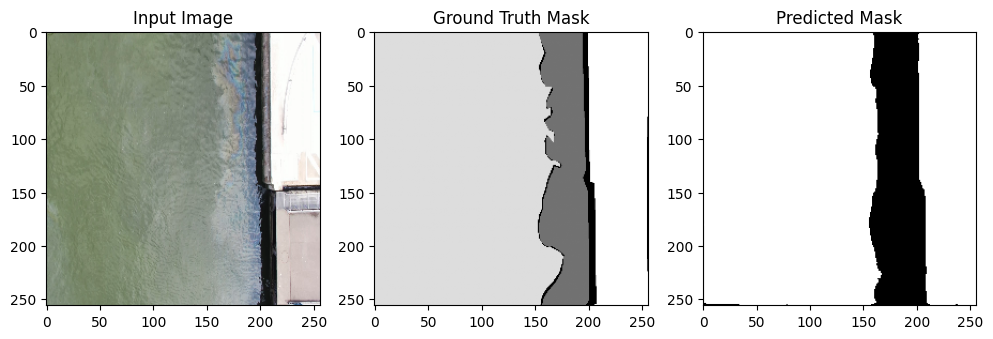

In [52]:
def show_comparison(img_path, mask_path, model):
    # Load and preprocess image
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_resized = cv2.resize(img, (IMG_SIZE, IMG_SIZE))

    # Preprocess for model
    inp = img_resized.astype("float32") / 255.0
    inp = np.expand_dims(inp, 0)

    # Prediction
    pred = model.predict(inp, verbose=0)[0, ..., 0]
    pred_bin = (pred > 0.5).astype("uint8") * 255

    # Ground truth
    gt = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    gt_resized = cv2.resize(gt, (IMG_SIZE, IMG_SIZE))

    # Plot side by side
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1); plt.imshow(img_resized); plt.title("Input Image")
    plt.subplot(1, 3, 2); plt.imshow(gt_resized, cmap="gray"); plt.title("Ground Truth Mask")
    plt.subplot(1, 3, 3); plt.imshow(pred_bin, cmap="gray"); plt.title("Predicted Mask")
    plt.show()

# Example
sample_file = sorted(os.listdir(TEST_IMG_DIR))[0]
show_comparison(
    os.path.join(TEST_IMG_DIR, sample_file),
    os.path.join(TEST_MASK_DIR, os.path.splitext(sample_file)[0] + ".png"),
    model
)


# **Overlay Segmentation Masks onto Input Images**

We overlay both ground truth mask and predicted mask on top of the input image using color maps.

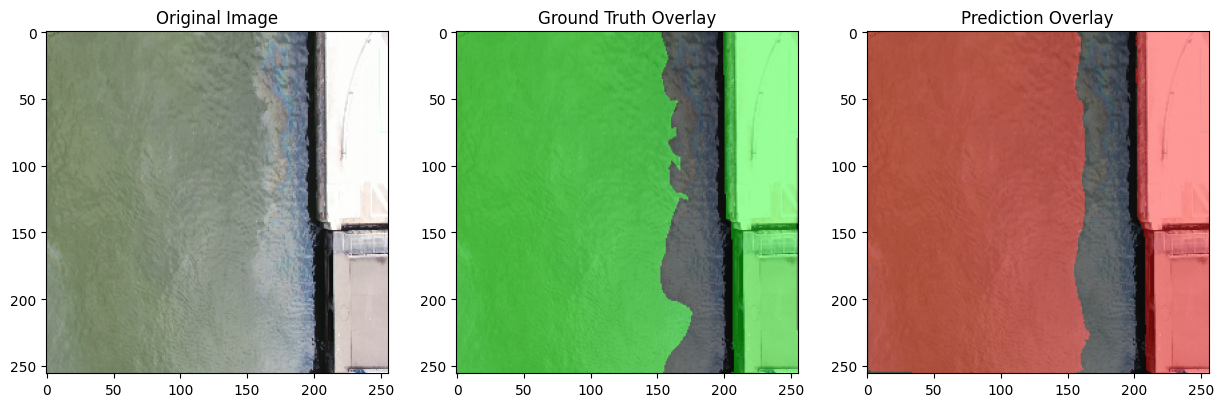

In [53]:
def overlay_mask(img, mask, color=(255, 0, 0), alpha=0.4):
    """Overlay mask on image with transparency"""
    overlay = img.copy()
    mask_colored = np.zeros_like(img)
    mask_colored[mask > 127] = color
    return cv2.addWeighted(mask_colored, alpha, overlay, 1 - alpha, 0)

def show_overlay(img_path, mask_path, model):
    # Load image
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_resized = cv2.resize(img, (IMG_SIZE, IMG_SIZE))

    # Prediction
    inp = img_resized.astype("float32") / 255.0
    inp = np.expand_dims(inp, 0)
    pred = model.predict(inp, verbose=0)[0, ..., 0]
    pred_bin = (pred > 0.5).astype("uint8") * 255

    # Ground truth
    gt = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    gt_resized = cv2.resize(gt, (IMG_SIZE, IMG_SIZE))

    # Overlays
    gt_overlay = overlay_mask(img_resized, gt_resized, color=(0, 255, 0))   # Green for GT
    pred_overlay = overlay_mask(img_resized, pred_bin, color=(255, 0, 0))  # Red for Prediction

    # Show
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1); plt.imshow(img_resized); plt.title("Original Image")
    plt.subplot(1, 3, 2); plt.imshow(gt_overlay); plt.title("Ground Truth Overlay")
    plt.subplot(1, 3, 3); plt.imshow(pred_overlay); plt.title("Prediction Overlay")
    plt.show()

# Example
show_overlay(
    os.path.join(TEST_IMG_DIR, sample_file),
    os.path.join(TEST_MASK_DIR, os.path.splitext(sample_file)[0] + ".png"),
    model
)


# Batch Visualization (Multiple Samples at Once)

We display multiple test samples together for a quick summary view.

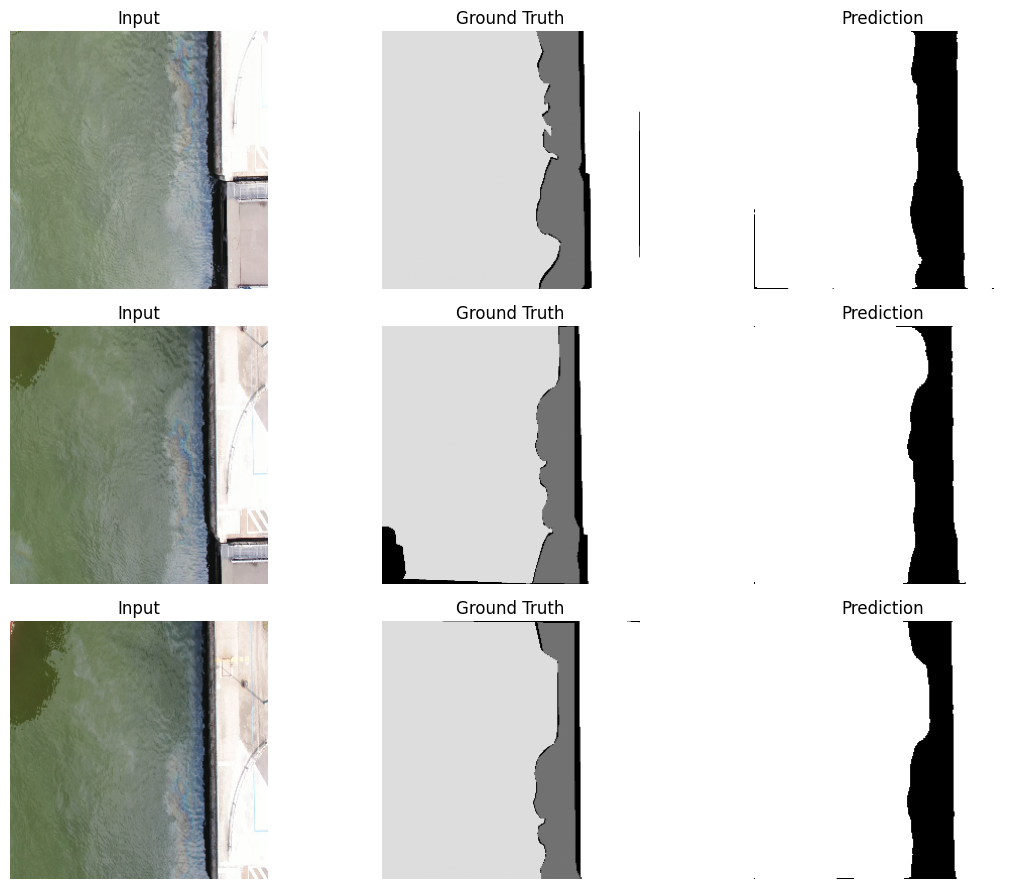

In [54]:
def batch_visualization(model, img_dir, mask_dir, n=4):
    files = sorted(os.listdir(img_dir))[:n]
    plt.figure(figsize=(12, n*3))

    for i, f in enumerate(files):
        img_path = os.path.join(img_dir, f)
        mask_path = os.path.join(mask_dir, os.path.splitext(f)[0] + ".png")

        # Load and preprocess
        img = cv2.imread(img_path); img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img_resized = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        inp = img_resized.astype("float32") / 255.0
        inp = np.expand_dims(inp, 0)

        # Prediction
        pred = model.predict(inp, verbose=0)[0, ..., 0]
        pred_bin = (pred > 0.5).astype("uint8") * 255
        gt = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        gt_resized = cv2.resize(gt, (IMG_SIZE, IMG_SIZE))

        # Plot 3 columns for each sample
        plt.subplot(n, 3, i*3 + 1); plt.imshow(img_resized); plt.axis("off"); plt.title("Input")
        plt.subplot(n, 3, i*3 + 2); plt.imshow(gt_resized, cmap="gray"); plt.axis("off"); plt.title("Ground Truth")
        plt.subplot(n, 3, i*3 + 3); plt.imshow(pred_bin, cmap="gray"); plt.axis("off"); plt.title("Prediction")

    plt.tight_layout()
    plt.show()

# Example batch
batch_visualization(model, TEST_IMG_DIR, TEST_MASK_DIR, n=3)


# Save Visual Summaries for Reports/Dashboards

We save predictions (side-by-side comparisons + overlays) into a folder for later reporting.

In [55]:
output_dir = "/content/oilspill_results"
os.makedirs(output_dir, exist_ok=True)

def save_visual_results(model, img_dir, mask_dir, n=5):
    files = sorted(os.listdir(img_dir))[:n]
    for f in files:
        img_path = os.path.join(img_dir, f)
        mask_path = os.path.join(mask_dir, os.path.splitext(f)[0] + ".png")

        img = cv2.imread(img_path); img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img_resized = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        inp = img_resized.astype("float32") / 255.0
        inp = np.expand_dims(inp, 0)

        pred = model.predict(inp, verbose=0)[0, ..., 0]
        pred_bin = (pred > 0.5).astype("uint8") * 255
        gt = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        gt_resized = cv2.resize(gt, (IMG_SIZE, IMG_SIZE))

        fig, ax = plt.subplots(1, 3, figsize=(12, 4))
        ax[0].imshow(img_resized); ax[0].set_title("Input"); ax[0].axis("off")
        ax[1].imshow(gt_resized, cmap="gray"); ax[1].set_title("Ground Truth"); ax[1].axis("off")
        ax[2].imshow(pred_bin, cmap="gray"); ax[2].set_title("Prediction"); ax[2].axis("off")

        save_path = os.path.join(output_dir, f"result_{os.path.splitext(f)[0]}.png")
        plt.savefig(save_path, bbox_inches="tight")
        plt.close()

    print(f"✅ Saved {n} result images to {output_dir}")

# Example save
save_visual_results(model, TEST_IMG_DIR, TEST_MASK_DIR, n=5)


✅ Saved 5 result images to /content/oilspill_results
